# Ensemble Learning Tutorial: Bagging vs Boosting on the Breast Cancer Wisconsin Dataset

In this tutorial, the goal is to **compare bagging and boosting** for binary classification using the Breast Cancer Wisconsin (Diagnostic) dataset.  
We will:

- Load and explore the dataset.
- Train a single decision tree as a baseline.
- Train a bagging model (Random Forest).
- Train a boosting model (Gradient Boosting or AdaBoost).
- Compare performance and discuss bias–variance, ethical issues, and practical guidance.


**Imports and basic setup**

In [1]:
# Basic imports
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from sklearn.datasets import load_breast_cancer

# Model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Base and ensemble models (we'll use them later)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Make plots look nicer
sns.set(style="whitegrid", context="notebook")

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Dataset: Breast Cancer Wisconsin (Diagnostic)

We use the **Breast Cancer Wisconsin (Diagnostic)** dataset, a classic binary classification dataset included in scikit-learn.
Each sample describes characteristics of a cell nucleus computed from a digitized image of a fine needle aspirate of a breast mass, with the target indicating whether the tumor is **malignant** or **benign**.


### Dataset, shape and target classes

In [2]:
# Load dataset from scikit-learn
data_bunch = load_breast_cancer()

# Extract features and target
X = data_bunch.data
y = data_bunch.target

# Feature and target names
feature_names = data_bunch.feature_names
target_names = data_bunch.target_names

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Feature names (first 5):", feature_names[:5])
print("Target names:", target_names)


Shape of X: (569, 30)
Shape of y: (569,)
Feature names (first 5): ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']
Target names: ['malignant' 'benign']


In [3]:
# Convert to pandas DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

# Map numeric target to class labels for readability
target_mapping = {0: "malignant", 1: "benign"}
df["target_label"] = df["target"].map(target_mapping)

df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,malignant


The dataset contains **569 samples** and **30 numeric features** describing characteristics of cell nuclei.  
The target variable has two classes: **malignant (0)** and **benign (1)**, which we will refer to using their class labels for interpretability.

### Class balance


Class counts:
 target_label
benign       357
malignant    212
Name: count, dtype: int64

Class percentages (%):
 target_label
benign       62.74
malignant    37.26
Name: proportion, dtype: float64


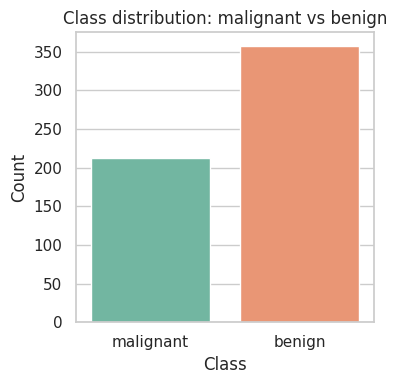

In [4]:
class_counts = df["target_label"].value_counts()
class_percentages = df["target_label"].value_counts(normalize=True) * 100

print("Class counts:\n", class_counts)
print("\nClass percentages (%):\n", class_percentages.round(2))

# Updated bar plot to avoid FutureWarning
plt.figure(figsize=(4, 4))
sns.countplot(x="target_label", hue="target_label", data=df,
              palette="Set2", legend=False)
plt.title("Class distribution: malignant vs benign")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



The dataset contains 569 samples, with **357 benign** cases and **212 malignant** cases.
Benign tumors account for about **62.74%** of the data, while malignant tumors account for about **37.26%**, so the classes are moderately imbalanced and accuracy alone may be misleading.

### Train, validation, and test split

In [5]:
# Separate features and target
X = df[feature_names].values
y = df["target"].values

# First split: train+val vs test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,   # 0.25 of 0.8 = 0.2, so 60/20/20 split overall
    stratify=y_train_val,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


Train size: 341
Validation size: 114
Test size: 114


We split the 569 samples into **60% training (341 samples)**, **20% validation (114 samples)**, and **20% test (114 samples)**, using stratified splits to preserve the benign/malignant ratio in each subset.
The training set is used to fit the models, the validation set to tune hyperparameters and compare bagging vs boosting, and the held-out test set to report final performance.


### Baseline: single decision tree

In [6]:
# Baseline model: single decision tree
tree_clf = DecisionTreeClassifier(
    max_depth=None,
    random_state=RANDOM_STATE
)

tree_clf.fit(X_train, y_train)

# Evaluate on train, validation, and test
def evaluate_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    y_tr_pred = model.predict(X_tr)
    y_v_pred = model.predict(X_v)
    y_te_pred = model.predict(X_te)

    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_v = accuracy_score(y_v, y_v_pred)
    acc_te = accuracy_score(y_te, y_te_pred)

    print(f"{name} accuracy:")
    print(f"  Train:      {acc_tr:.3f}")
    print(f"  Validation: {acc_v:.3f}")
    print(f"  Test:       {acc_te:.3f}")
    return acc_tr, acc_v, acc_te

tree_accs = evaluate_model(
    "Decision Tree",
    tree_clf,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)


Decision Tree accuracy:
  Train:      1.000
  Validation: 0.956
  Test:       0.904


A single `DecisionTreeClassifier` achieves **100% accuracy on the training set**, **95.6% on the validation set**, and **90.4% on the test set**.
The perfect training accuracy together with lower validation and test accuracy suggests the tree is **overfitting**, which makes it a good baseline to compare against bagging and boosting methods designed to improve generalization.

### Bagging with Random Forest


In [7]:
# Bagging model: Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

rf_accs = evaluate_model(
    "Random Forest",
    rf_clf,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)


Random Forest accuracy:
  Train:      1.000
  Validation: 0.956
  Test:       0.947


The Random Forest model (200 trees) also reaches **100% training accuracy**, **95.6% validation accuracy**, and improves the **test accuracy to 94.7%** compared with the single tree.
By averaging many decorrelated trees trained on bootstrap samples, bagging reduces variance and yields a more robust model that generalizes better to unseen data than a single deep tree.


### Boosting with Gradient Boosting

In [8]:
# Boosting model: Gradient Boosting
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)

gb_clf.fit(X_train, y_train)

gb_accs = evaluate_model(
    "Gradient Boosting",
    gb_clf,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)


Gradient Boosting accuracy:
  Train:      1.000
  Validation: 0.947
  Test:       0.930


The Gradient Boosting model with 200 shallow trees reaches **100% training accuracy**, **94.7% validation accuracy**, and **93.0% test accuracy**.
Boosting builds an ensemble sequentially, where each new tree focuses on correcting the errors of the previous ones, which typically reduces bias and can achieve strong performance, but may also be more sensitive to hyperparameters and noise compared with bagging.


## Summary table of model accuracies

In [9]:
# Combine results into a DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest (bagging)", "Gradient Boosting (boosting)"],
    "Train accuracy": [tree_accs[0], rf_accs[0], gb_accs[0]],
    "Validation accuracy": [tree_accs[1], rf_accs[1], gb_accs[1]],
    "Test accuracy": [tree_accs[2], rf_accs[2], gb_accs[2]],
})

results_df


,Model,Train accuracy,Validation accuracy,Test accuracy
0,Decision Tree,1.0,0.956140,0.903509
1,Random Forest (bagging),1.0,0.956140,0.947368
2,Gradient Boosting (boosting),1.0,0.947368,0.929825


### Accuracy comparison: tree, bagging, and boosting

The table below compares training, validation, and test accuracy for all three models. Both ensemble methods outperform the single decision tree on the test set, with Random Forest (bagging) achieving the highest test accuracy, illustrating how averaging many trees reduces variance more effectively on this dataset than boosting with the chosen hyperparameters.

## Confusion matrices for all models

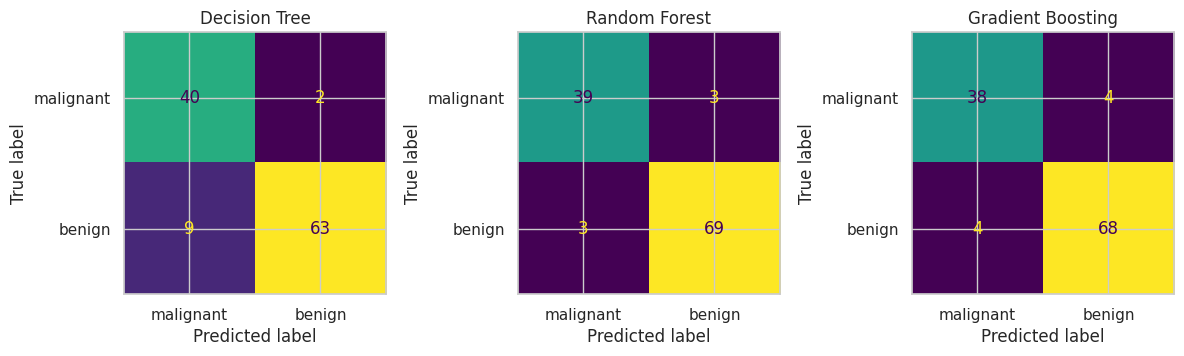

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

models = {
    "Decision Tree": tree_clf,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf,
}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=target_names
    )
    disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()


## Classification report for Random Forest

In [11]:
from sklearn.metrics import classification_report

y_test_pred_rf = rf_clf.predict(X_test)
print("Random Forest classification report (test set):")
print(classification_report(y_test, y_test_pred_rf, target_names=target_names))


Random Forest classification report (test set):
              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        42
      benign       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



### Error analysis for Random Forest

On the test set, the Random Forest correctly classifies **39 malignant** and **69 benign** cases, with **3 malignant tumors misclassified as benign** and **3 benign tumors misclassified as malignant**.
The classification report shows precision and recall around **0.93 for malignant** and **0.96 for benign**, with an overall accuracy of **0.95**, indicating strong performance but still some clinically important false negatives where malignant cases are predicted as benign.


### Ethical considerations

In a medical diagnosis context, misclassifying a **malignant tumor as benign** (false negative) can delay treatment and pose serious risks, so models should be evaluated not only on accuracy but also on recall for the malignant class and the consequences of different error types.
Ensemble methods like Random Forest can reduce variance and improve robustness, but they still depend on the quality and representativeness of the training data, so biases or sampling issues in the dataset may lead to unfair or unsafe predictions if deployed without proper validation.

### Random Forest feature importance

The Random Forest assigns highest importance to features related to the **worst concave points, worst perimeter, and worst area**, followed by mean concave points and mean concavity.  
These measurements summarize the shape and size of the tumor, suggesting that irregular, larger masses are strong indicators of malignancy in the model; this aligns with clinical intuition but still requires domain expert validation before deployment.


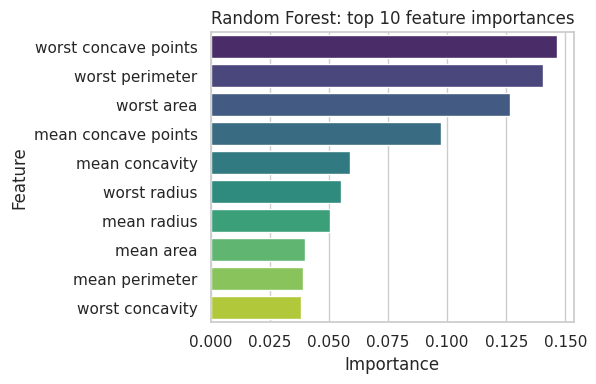

In [12]:
# Feature importances from Random Forest
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 10  # show top 10 features
top_features = [feature_names[i] for i in indices[:top_k]]
top_importances = importances[indices[:top_k]]

plt.figure(figsize=(6, 4))
sns.barplot(
    x=top_importances,
    y=top_features,
    hue=top_features,
    dodge=False,
    legend=False,
    palette="viridis"
)
plt.title("Random Forest: top 10 feature importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Effect of ensemble size on validation accuracy

When varying the number of trees from 10 to 200, the **Random Forest** validation accuracy increases from about **0.93 with 10 trees** to **0.956 with 50 trees**, and then stabilizes around **0.956** for larger ensembles, illustrating how bagging mainly reduces variance and quickly reaches a plateau in this dataset.
For **Gradient Boosting**, validation accuracy peaks around **0.956** for 50–100 trees but slightly drops back to **0.947** at 200 trees, highlighting that boosting is more sensitive to hyperparameters and may start overfitting if the ensemble becomes too large without adjusting learning rate or regularization.


In [13]:
n_estimators_list = [10, 50, 100, 200]

rf_val_acc = []
gb_val_acc = []

for n in n_estimators_list:
    rf_tmp = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_tmp.fit(X_train, y_train)
    rf_val_acc.append(accuracy_score(y_val, rf_tmp.predict(X_val)))

    gb_tmp = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE
    )
    gb_tmp.fit(X_train, y_train)
    gb_val_acc.append(accuracy_score(y_val, gb_tmp.predict(X_val)))

rf_val_acc, gb_val_acc


([0.9298245614035088, 0.956140350877193, 0.956140350877193, 0.956140350877193],
 [0.9473684210526315,
  0.956140350877193,
  0.956140350877193,
  0.9473684210526315])

### Visual comparison of bagging and boosting

The validation-accuracy curves show that **Random Forest (bagging)** improves from about 0.93 with 10 trees to around 0.956 with 50 trees, and then remains stable as more trees are added.
**Gradient Boosting (boosting)** starts slightly stronger at small ensemble sizes, peaks around 0.956 for 50–100 trees, and then drops slightly at 200 trees, illustrating that boosting is more sensitive to overfitting and hyperparameters, whereas bagging mainly reduces variance and benefits from larger ensembles.


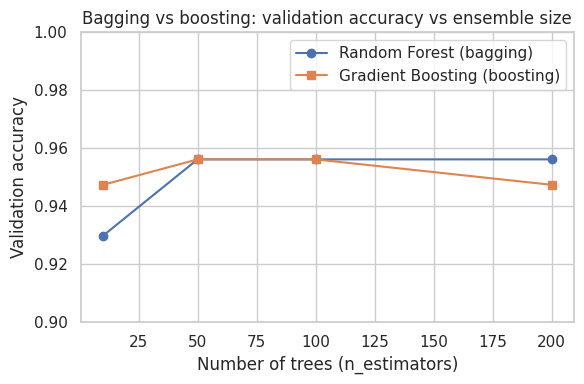

In [14]:
plt.figure(figsize=(6, 4))

plt.plot(n_estimators_list, rf_val_acc, marker="o", label="Random Forest (bagging)")
plt.plot(n_estimators_list, gb_val_acc, marker="s", label="Gradient Boosting (boosting)")

plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Validation accuracy")
plt.title("Bagging vs boosting: validation accuracy vs ensemble size")
plt.ylim(0.90, 1.0)
plt.legend()
plt.tight_layout()
plt.show()
